In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib.collections import LineCollection
import numba
from matplotlib import colors as mcolors
import pandas as pd

import matplotlib.pyplot as plt; plt.rcdefaults()
from scipy import stats
import matplotlib.mlab as mlab
import math

In [ ]:
# ***** To Do: write the location of locust_posture_data.h5 *****
posture_data_location = '___'

In [2]:
body_parts = pd.read_csv('skeleton.csv').values
skeleton = np.load('locust_skeleton.npy')

In [3]:
def get_data(frame, skeleton):
    """ Export data from h5 file: 'locust_posture_data.h5'
    
    Parameters
    ----------
    frame : int
        Frame number of which data will be exported from

    skeleton : array-like
        Array containing x,y coordinates, shape: (35, 2)
    
    Returns
    -------
    allLocusts : list, 
        List of line segments that make up each individual 
        locust, shape: (103, 26, 2, 2)
    
    totalIndividuals: int
        Number of total locusts in the posture data 
    """
    with h5py.File(posture_data_location) as h5file:
        compressed = h5file['joints'][:,frame,...,:2]

    N_INDIVID = len(compressed)
    allLocusts = [] # empty list. fill this will all individual's line segment stacks

    for individ in range(N_INDIVID):
        line_segments = [] # empty list
        for idx, jdx in enumerate(skeleton[:,0]):
            if jdx != -1: # if node has parent... 
                line_segments.append(compressed[individ][[idx,jdx]])
        allLocusts.append(np.stack(line_segments))  
        # shape of line_segments (26, 2, 2)
        # shape of allLocusts (103, 26, 2, 2)
        totalIndividuals = len(line_segments)
    return allLocusts, totalIndividuals

In [4]:
@numba.njit(fastmath=True)
def det(a, b, c, d):    
    return a*d - b*c

@numba.njit(fastmath=True)
def line_line_intersection(a, b):
    
    intersects = False
    intersection = np.empty((1,2))+np.nan

    x1 = a[0,0]
    x2 = a[1,0]
    y1 = a[0,1]
    y2 = a[1,1]
    
    x3 = b[0,0]
    x4 = b[1,0]
    y3 = b[0,1]
    y4 = b[1,1]
    
    dxa = x1 - x2
    dxb = x3 - x4
        
    dya = y1 - y2
    dyb = y3 - y4
    
    denominator = det(dxa, dya, dxb, dyb)
    parallel = denominator == 0
    
    if not parallel:
        
        dyab = y4 - y1
        dxab = x4 - x1
        lamda = ((-dyb) * (dxab) + (dxb) * (dyab)) / denominator
        gamma = ((dya) * (dxab) + (-dxa) * (dyab)) / denominator
        intersects = (0 < lamda < 1) & (0 < gamma < 1)
        
        ''' # previous method of checking endpoint intersecting limb
        dxc = x1 - x3
        dyc = y1 - y3

        dxl = x4 - x1
        dyl = y4 - y3

        # check if point is on the line
        cross = dxc * dyl - dyc * dxl
            
        if cross == 0: # point is on line. count this as an intersection
            intersects = True
        
        # new method of checking endpoint intersecting limb
        if not intersects: # check if limb of locustA contains point of limbB
            # check overlap
            intersects, intersection = check_all_overlap(x1, y1, x2, y2, x3, y3, x4, y4)       
        if intersects: # calculate point of intersection

            det_a = det(x1, y1, x2, y2)
            det_c = det(x3, y3, x4, y4)

            x = det(det_a, dxa, det_c, dxb) / denominator

            y = det(det_a, dya, det_c, dyb) / denominator

            intersection[0,0] = x
            intersection[0,1] = y
    '''
    return intersects, intersection

@numba.njit(fastmath=True)
def get_intersection_matrix(line_segments_A, line_segments_B):  
    """ Get intersection matrix between locust A and B
    
    Parameters
    ----------
    line_segments_A : {array-like, sparse matrix}, shape (26, 2, 2)
        Line segments of locust A
        
    line_segments_B : {array-like, sparse matrix}, shape (26, 2, 2)
        Line segments of locust B
    
    Returns
    -------
    intersection_matrix : {array-like, sparse matrix}, shape (26, 26)
        Intersection matrix between Locust A's 26 limbs and B's 26 limbs
    
    """
    intersection_matrix = np.zeros((26, 26))
    for Adx in range(len(line_segments_A)):
        jointA  = line_segments_A[Adx] # for each joint in locust A
        for Bdx in range(len(line_segments_B)):
            jointB = line_segments_B[Bdx] # for each joint in Locust B
            if (line_line_intersection(jointA, jointB)[0]): # if there is an intersection between joints
                intersection_matrix[Adx, Bdx]=1
                break
    return intersection_matrix

In [5]:
@numba.njit(parallel=True)
def get_adjmatrix(N_INDIVID, N_SEGMENTS, allLocusts):
    """ Get an large  intersection matrix of size (N_INDIVID, N_INDIVID, N_SEGMENTS, N_SEGMENTS) 
    
    Parameters
    ----------
    N_INDIVID: int
        Number of individual locusts (103)
    N_SEGMENTS: int
        Number of line segments that make up locusts body (26)
    allLocusts : list , shape: (26, 2, 2)
        contains the line segments that make up the joints of all the locusts
       
        
    Returns
    -------
    adj_matrix : {array-like, sparse matrix}, shape (103, 103, 26, 26)
       
    """
    adj_matrix = np.zeros((N_INDIVID, N_INDIVID, N_SEGMENTS, N_SEGMENTS))
    for locustA in numba.prange(N_INDIVID):
    # for locustA in range(N_INDIVID):
        # for locustB in range(N_INDIVID):
        for locustB in numba.prange(N_INDIVID):
            if (locustA != locustB): # only the interaction matrix of locust interacting with other individuals
                intersection = get_intersection_matrix(allLocusts[locustA], allLocusts[locustB])
                adj_matrix[locustA, locustB, :, :] = intersection  
    return adj_matrix

In [6]:
def get_pairwise(init_frame, time_window):
        
    """ Get Time Series Data with shape (N_INDIVID, time_window, segments, segments)
            touching : boolean
                in x frames back, is LocustA touching LocustB?
    
    Parameters
    ----------
    init_frame: int
        Initial frame
    time_window: int
        How many frames are you going back
       
        
    Returns
    -------
    TS_data : {array-like, sparse matrix}, shape (103, time_window, 26, 26)
        Obtain time series data 
       
    """
        
    TS_data = np.zeros((103, time_window, 26, 26))
    ts_count = 0
    skeleton = np.load('locust_skeleton.npy')
    
    for frame in range(init_frame - time_window + 1, init_frame + 1): # ex: frame 5-10 (inclusive)
        print("frame", frame)
        allLocusts, N_SEGMENTS = get_data(frame = frame, skeleton = skeleton) # allLocusts = data of locust joints # N_SEGMENTS = 26 
        N_INDIVID = len(allLocusts) # 103

        #get adjacency matrix (103, 103, 26, 26) with 0/1 for touching
        adjM = get_adjmatrix(N_INDIVID, N_SEGMENTS, allLocusts)
        adjM = np.sum(adjM, axis=1) # shape: 103, 26, 26, sum up interactions with all other locust's limbs 
        print(adjM.shape)

        for locust in range(N_INDIVID):
            TS_data[locust, ts_count, :, :]=adjM[locust]
        ts_count += 1
    return TS_data

### Get Data

In [7]:
totalFrames=324399
# totalFrames=48 # for testing

In [9]:
batch1 = get_pairwise(int(totalFrames/3)-1, int(totalFrames/3))

frame 0
(103, 26, 26)
frame 1
(103, 26, 26)
frame 2
(103, 26, 26)
frame 3
(103, 26, 26)
frame 4
(103, 26, 26)
frame 5
(103, 26, 26)
frame 6
(103, 26, 26)
frame 7
(103, 26, 26)
frame 8
(103, 26, 26)
frame 9
(103, 26, 26)
frame 10
(103, 26, 26)
frame 11
(103, 26, 26)
frame 12
(103, 26, 26)
frame 13
(103, 26, 26)
frame 14
(103, 26, 26)
frame 15
(103, 26, 26)


In [10]:
batch1.shape

(103, 16, 26, 26)

In [ ]:
with h5py.File('26x26_batch1.h5', 'w') as h5File:
    h5File.create_dataset('batch1', data=batch1)

In [11]:
batch2 = get_pairwise(int(2*totalFrames/3)-1, int(totalFrames/3))

frame 16
(103, 26, 26)
frame 17
(103, 26, 26)
frame 18
(103, 26, 26)
frame 19
(103, 26, 26)
frame 20
(103, 26, 26)
frame 21
(103, 26, 26)
frame 22
(103, 26, 26)
frame 23
(103, 26, 26)
frame 24
(103, 26, 26)
frame 25
(103, 26, 26)
frame 26
(103, 26, 26)
frame 27
(103, 26, 26)
frame 28
(103, 26, 26)
frame 29
(103, 26, 26)
frame 30
(103, 26, 26)
frame 31
(103, 26, 26)


In [12]:
batch2.shape

(103, 16, 26, 26)

In [ ]:
with h5py.File('26x26_batch2.h5', 'w') as h5File:
    h5File.create_dataset('batch2', data=batch2)

In [13]:
batch3 = get_pairwise(int(3*totalFrames/3)-1, int(totalFrames/3))

frame 32
(103, 26, 26)
frame 33
(103, 26, 26)
frame 34
(103, 26, 26)
frame 35
(103, 26, 26)
frame 36
(103, 26, 26)
frame 37
(103, 26, 26)
frame 38
(103, 26, 26)
frame 39
(103, 26, 26)
frame 40
(103, 26, 26)
frame 41
(103, 26, 26)
frame 42
(103, 26, 26)
frame 43
(103, 26, 26)
frame 44
(103, 26, 26)
frame 45
(103, 26, 26)
frame 46
(103, 26, 26)
frame 47
(103, 26, 26)


In [14]:
batch3.shape

(103, 16, 26, 26)

In [ ]:
with h5py.File('26x26_batch3.h5', 'w') as h5File:
    h5File.create_dataset('batch3', data=batch3)

In [15]:
# concatenate based on the 1st axis (frames)
X=np.concatenate((batch1, batch2, batch3), axis=1)
X.shape

(103, 48, 26, 26)

### Get Y Data: Movement Classification

In [16]:
with h5py.File('moving_classification_og_head.h5', 'r') as h5File:
    moving_classification_h5 = h5File.get('moving_classification')
    moving_classification = np.array(moving_classification_h5)
moving_classification.shape

(103, 324399)

In [17]:
def get_TS_movement(moving_classification, init_frame, time_window):
    """ Get Time Series Movement Classification Data 
            time_window : how many frames you go back
            
    Parameters
    ----------
    moving_classification : {array-like, sparse matrix}, shape = (103, 108133)
        0/1: Is locust moving (1) or paused (0)? 
    init_frame: int
        Initial frame
    time_window: int
        How many frames are you going back
       
        
    Returns
    -------
    TS_data : {array-like, sparse matrix}, shape (N_INDIVID, time_window, 
                                                    movement_classification)
        Obtain time series data (Dependent variable, predictor)
    """
    TS_data = np.zeros((103, time_window, 1))
    skeleton = np.load('locust_skeleton.npy')
    ts_count = 0
    for frame in range(init_frame - time_window + 1, init_frame + 1): # ex: frame 5-10 (inclusive)
        #get movement classification
        for LocustA in range(103):
            TS_data[LocustA, ts_count, 0] = moving_classification[LocustA][frame]
        ts_count += 1
    return TS_data

In [18]:
y = get_TS_movement(moving_classification, totalFrames-1, totalFrames)

In [19]:
with h5py.File('all_movement.h5', 'w') as h5File:
    h5File.create_dataset('y', data=y)

### Data Analysis

In [20]:
y=y[:, 0:totalFrames, :]

In [21]:
# ((103, totalFrames, 26, 26), (103, totalFrames, 1))
X.shape, y.shape 

((103, 48, 26, 26), (103, 48, 1))

#### Functions

In [22]:
def classification(X, classification):
    """ fill array: newX, to determine if the locust is touching the front/back, left/right. 
        Only used for 
            
    Parameters
    ----------
    classification : array, shape = (26, )
        Number to classify the part of the body of the locust
    X : {array-like, sparse matrix}  shape (N_INDIVID, time_window, 
                                            movement_classification)
       
        
    Returns
    -------
    TS_data : {array-like, sparse matrix}, shape (N_INDIVID, time_window, 
                                                    movement_classification)
        Obtain time series data (Dependent variable, predictor)
    """
    template=np.zeros((X.shape[0],X.shape[1],1))
    newX=np.full_like(template, np.nan)
    
    # count = np.zeros((4))
    limb_count = np.zeros((len(body_parts)))

    for locust in range(X.shape[0]):
        for frame in range(X.shape[1]):
            interaction = np.sum(X[locust, frame, :])

            if (interaction>1): # touching multiple limbs
                index = np.array(X[locust, frame, :].nonzero())[0] # get index to identify the limb
                
                classification_sum=0
                for idx in index:
                    if (not np.isnan(classification[idx])):
                        # count[int(classification[idx])]+=1
                        limb_count[idx]+=1
                        classification_sum+=classification[idx]
                avg_classification=classification_sum/index.shape[0]
                if avg_classification==0: # if all the limbs are touching front, record as front
                    newX[locust, frame, 0] = 0
                if avg_classification==1: # if all the limbs are touching back, record as back
                    newX[locust, frame, 0] = 1
                # else: if touching on front and back, keep newX value as np.nan

            if (interaction==1): # touching *one* other limb
                index = np.nonzero(X[locust, frame, :]) # get index to identify the limb
                if (not np.isnan(classification[index][0])):
                    newX[locust, frame, 0] = classification[index][0] # get classification
                    # count[int(classification[index][0])]+=1
                    limb_count[index]+=1
            
    return newX, limb_count #, count

In [23]:
def get_past(individ, frame, framesback, newX, zero, one, five, threeone):
    # get array of past X frames
    for frameback in range(framesback):
        if newX[individ, frame-frameback]==0: 
            zero[frameback]+=1
        if newX[individ, frame-frameback]==1: 
            one[frameback]+=1
        if newX[individ, frame-frameback]==5: 
            five[frameback]+=1
        if newX[individ, frame-frameback]==31: 
            threeone[frameback]+=1
    return zero, one, five, threeone
    
def history(newX, framesback, region, want_PL_or_Greater, pause_length, filter_frames=0):
    zero=np.zeros(framesback)
    one=np.zeros(framesback)
    five=np.zeros(framesback)
    threeone=np.zeros(framesback) 
                    
    speed_changes = 0
    for individ in range(y.shape[0]):
        for frame in range(framesback, y.shape[1]-filter_frames):
            
            if filter_frames>0: #  Filtering out the brief changes in motion 
                past, future=0,0
                for numb in range(filter_frames):
                    past+=y[individ, frame-(numb+1)]
                    future+=y[individ, frame+numb]
                # Keep data points where locust was paused for X frames, moving for X frames
                if (future-past)==filter_frames:
                    speed_changes+=1
                    zero, one, five, threeone=get_past(individ, frame, framesback, newX, zero, one, five, threeone) # count 
                    
            elif filter_frames==0: # no filtering
                past=0
                for prev in range(pause_length):
                    past += y[individ, frame-(prev+1)] # 0
                if want_PL_or_Greater: # if the locust has a consecutive pause of length X or greater 
                    if past==0:
                        if (y[individ, frame] - y[individ, frame-1])==1: 
                            speed_changes+=1
                            zero, one, five, threeone=get_past(individ, frame, framesback, newX, zero, one, five, threeone) # count 
                # if the locust has a consecutive pause of length and in the frame before the pause length, it was moving. Only counting interactions of pause length = 1 (no others!)
                else: 
                    if past==0 and y[individ, frame-(pause_length+1)]==1:
                        if (y[individ, frame] - y[individ, frame-1])==1: 
                            speed_changes+=1
                            zero, one, five, threeone=get_past(individ, frame, framesback, newX, zero, one, five, threeone) # count 
                                    
    if (region=='FB' or region=='LR'): # FB and LR only have 0 and 1 as classification numbers 
        print("speed changes: ", speed_changes)
        plot_two(zero/speed_changes, one/speed_changes, framesback, region, want_PL_or_Greater, filter_frames, pause_length)

    if region=='AFMB': # AFMB has 0, 1, 5, 31 as classification numbers
        ant, front, middle, back, = zero/speed_changes, one/speed_changes, five/speed_changes, threeone/speed_changes
        print("speed changes: ", speed_changes)
        plot_AFMB(ant, front, middle, back, framesback, region, want_PL_or_Greater, filter_frames, pause_length)

In [24]:
def plot_AFMB(ant, front, middle, back, framesback, region, want_PL_or_Greater, filter_frames, pause_length):
    
    ind = np.arange(framesback)  # the x locations for the groups
    
    width=0.20
    fig, ax = plt.subplots()

    X = np.arange(framesback)
    p1=ax.bar(X + 0.00, ant, color = 'b', width = width)
    p2=ax.bar(X + 0.20, front, color = 'g', width = width)
    p3=ax.bar(X + 0.40, middle, color = 'r', width = width)
    p4=ax.bar(X + 0.60, back, color = 'y', width = width)

    ax.set_xlabel('Number of frames back in time', fontsize=20)
    ax.set_ylabel('P(Locust touches other with this limb)', fontsize=20)
    if filter_frames>0: 
        ax.set_title('Probability the locusts will touch with their limb in the previous %d frames before a change from paused to moving is observed; filter length: %d' % (framesback, filter_frames), fontsize=20)
    else: 
        ax.set_title('Probability the locusts will touch with their limb in the previous %d frames before a change from paused to moving is observed; paused length: %d' % (framesback, pause_length), fontsize=20)
    ax.set_xticks(np.arange(framesback))
    ax.legend((p1[0], p2[0], p3[0], p4[0]), ('Antennae', 'Front', 'Middle', 'Back'), fontsize=20)
    fig.set_size_inches((30, 12))
    if filter_frames>0: 
        fig.savefig('./plots/AFMB/AFMB_filter%d.png' % filter_frames) 
    elif want_PL_or_Greater: 
        fig.savefig('./plots/AFMB/AFMB_%d_or_more.png' % pause_length)
    else: 
        fig.savefig('./plots/AFMB/AFMB_only%d.png' % pause_length)
    
    plt.show()

In [25]:
def plot_two(front, back, framesback, region, want_PL_or_Greater, filter_frames, pause_length):
    ind = np.arange(len(front))  # the x locations for the groups
    width = 0.25  # the width of the bars
    if region=='FB': 
        labels = ['Front', 'Back']
    elif region=='LR':
        labels = ['Left', 'Right']

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width/2, front, width, label=labels[0])
    rects2 = ax.bar(ind + width/2, back, width, label=labels[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('P(Locust touches other with this limb)')
    ax.set_xlabel('Duration Periods (in frames)')
    if filter_frames>0: 
        ax.set_title('Probability the locusts will touch with their limb in the previous %d frames \n before a change from paused to moving is observed; filter length: %d' % (framesback, filter_frames), fontsize=10)
    else: 
        ax.set_title('Probability the locusts will touch with their limb in the previous %d frames \n before a change from paused to moving is observed; paused length: %d' % (framesback, pause_length), fontsize=10)
    ax.set_xticks(ind)
    ax.set_xticklabels(np.arange(framesback))
    ax.legend()
    if filter_frames>0: 
        fig.savefig('./plots/%s/%s_filter%d.png' % (region, region, filter_frames))
    elif want_PL_or_Greater: 
        fig.savefig('./plots/%s/%s_%d_or_more.png' % (region, region, pause_length))
    else: 
        fig.savefig('./plots/%s/%s_only%d.png' % (region, region, pause_length))
    plt.show()

Limb Interaction Heatmap 

In [26]:
def heatmap(limb_count):
    with h5py.File('Locust_Template.h5', 'r') as h5File:
        allLocusts = h5File.get('allLocusts')
        allLocusts = np.array(allLocusts)

    N_INDIVID = len(allLocusts)
    fig = plt.figure(figsize=(5,10))
    ax = plt.gca()
    # for limb 
    for limb in range(np.array(allLocusts).shape[1]):
        i=limb+1
        if i==26:
            line_collection = LineCollection((allLocusts[0][limb], allLocusts[1][0]), colors=plt.cm.gist_heat(limb_count[limb]/np.max(limb_count)), cmap='copper')
        else:
            line_collection = LineCollection((allLocusts[0][limb], allLocusts[0][i]), colors=plt.cm.gist_heat(limb_count[limb]/np.max(limb_count)), cmap='copper')
        ax.add_collection(line_collection)

    plt.xlim(970,1040)
    plt.ylim(1425,1510)
    fig.savefig('./plots/%s/%s_heatmap.png' % (region, region))
    plt.show()

### Individual Locust's Limb Interactions

#### Data Preparation

In [27]:
# given the body_parts array, classify the body parts as FB/LR (based on the list of body parts)
# 0: front, 1: back
classification_fb=np.array([0,0,1,1,0,0,0,0,0,np.nan,np.nan,np.nan,1,1,1,0,0,0,0,0,np.nan,np.nan,np.nan,1,1,1])

# 0: left, 1: right
classification_lr=np.array([np.nan,np.nan,np.nan,np.nan,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1])

# antennae=0; front=1; middle=5; back=31
classification_AFMB=np.array([np.nan,np.nan,np.nan,np.nan,0,0,1,1,1,5,5,5,31,31,31,0,0,1,1,1,5,5,5,31,31,31])

In [28]:
X_26=np.sum(X, axis=3)
X_26.shape

(103, 48, 26)

#### Plots
Plots saved under ./plots/

In [29]:
! mkdir plots
! mkdir plots\pairwise
! mkdir plots\FB
! mkdir plots\AFMB
! mkdir plots\LR

In [30]:
# Alter the Pause_Length
pause_lengths = [1, 3, 9, 18]
framesback=30 # ** CHANGE TO 300

AFMB: Antennae, Front, Middle, Back

In [31]:
X_AFMB, limb_count = classification(X_26, classification_AFMB)

speed changes:  41


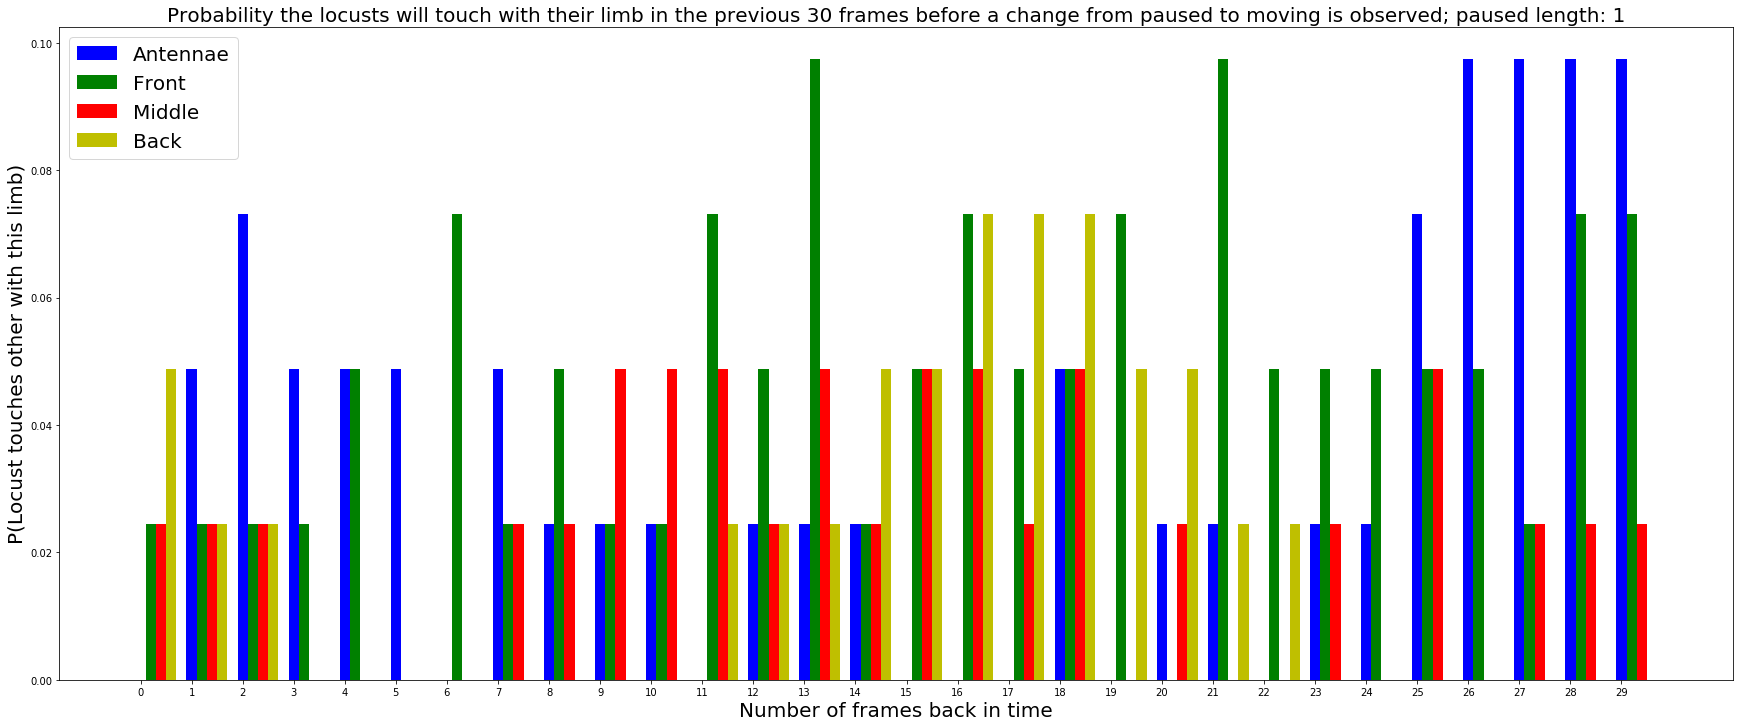

speed changes:  19


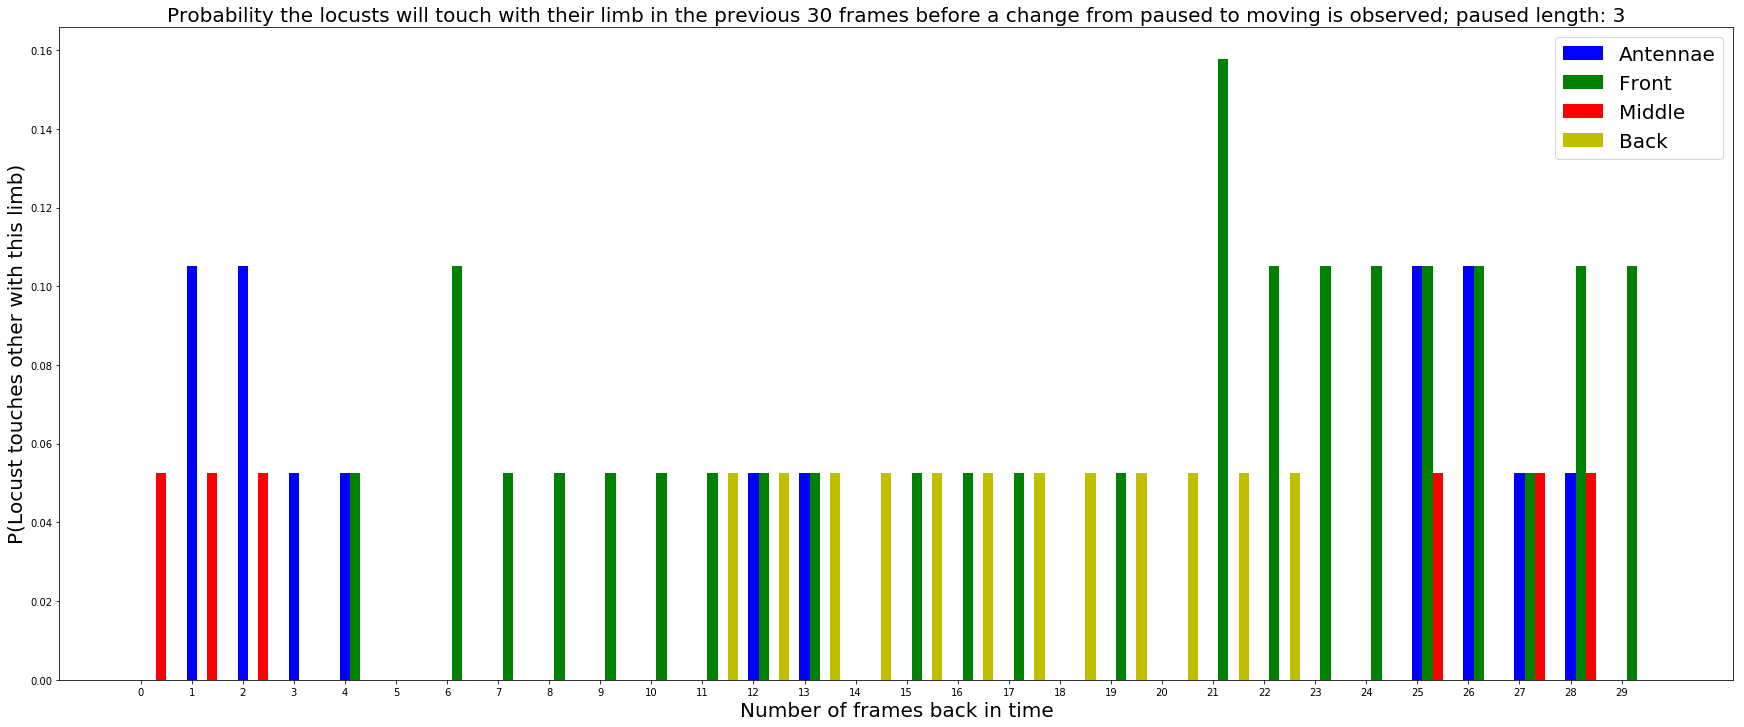

speed changes:  12


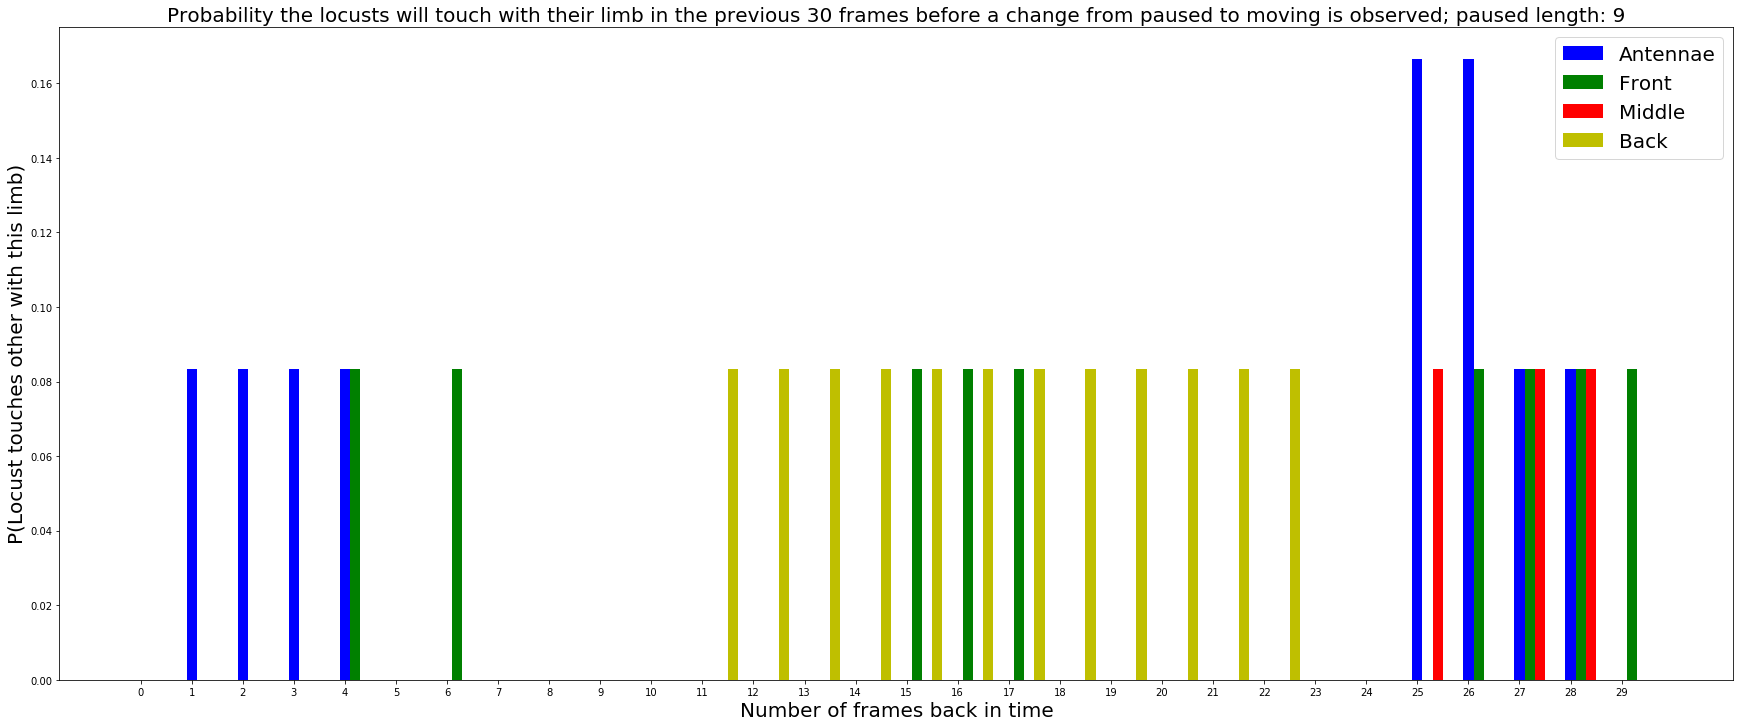

speed changes:  7


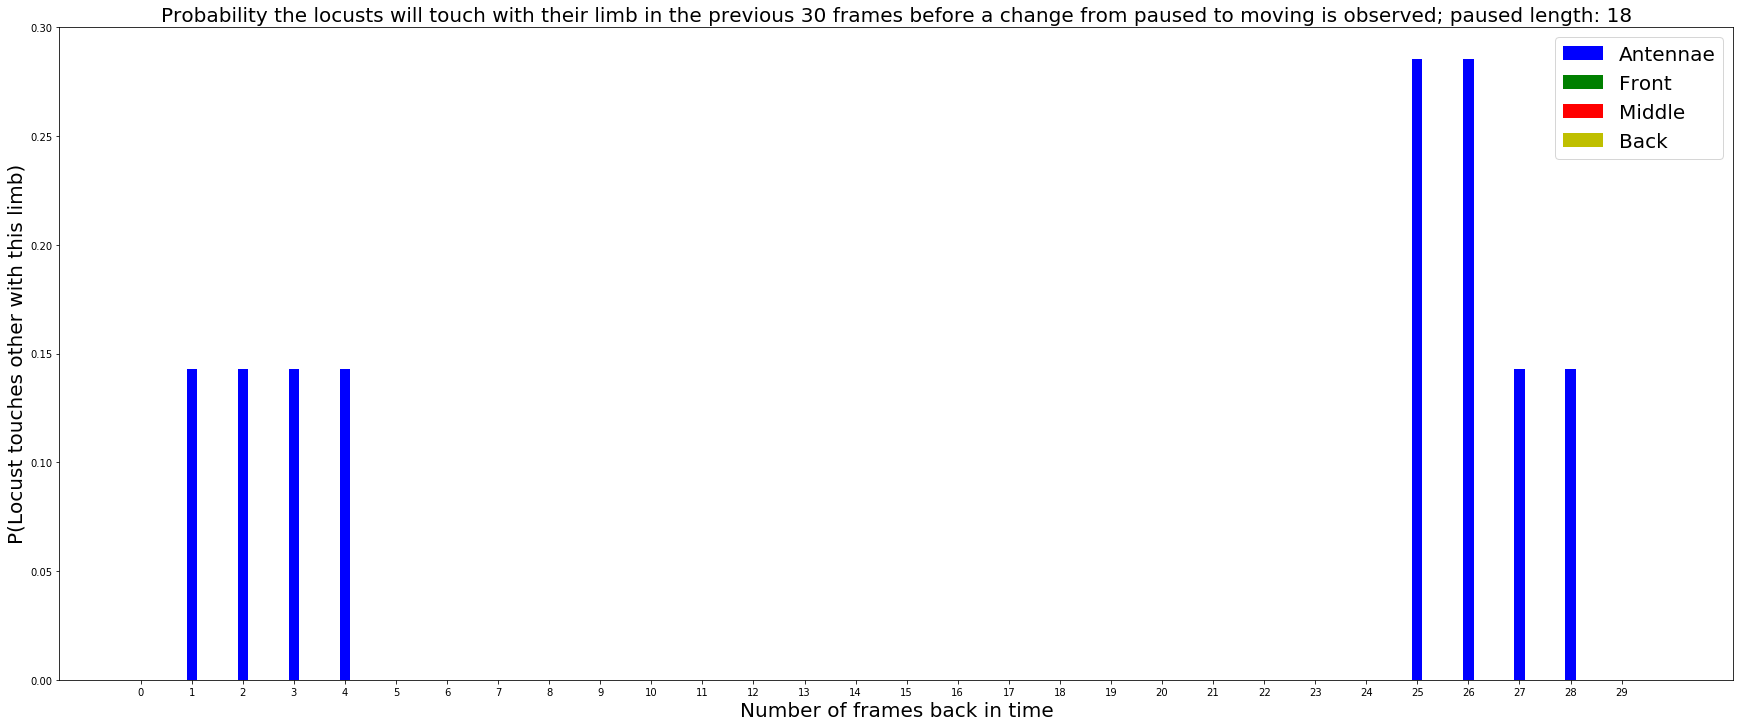

speed changes:  17


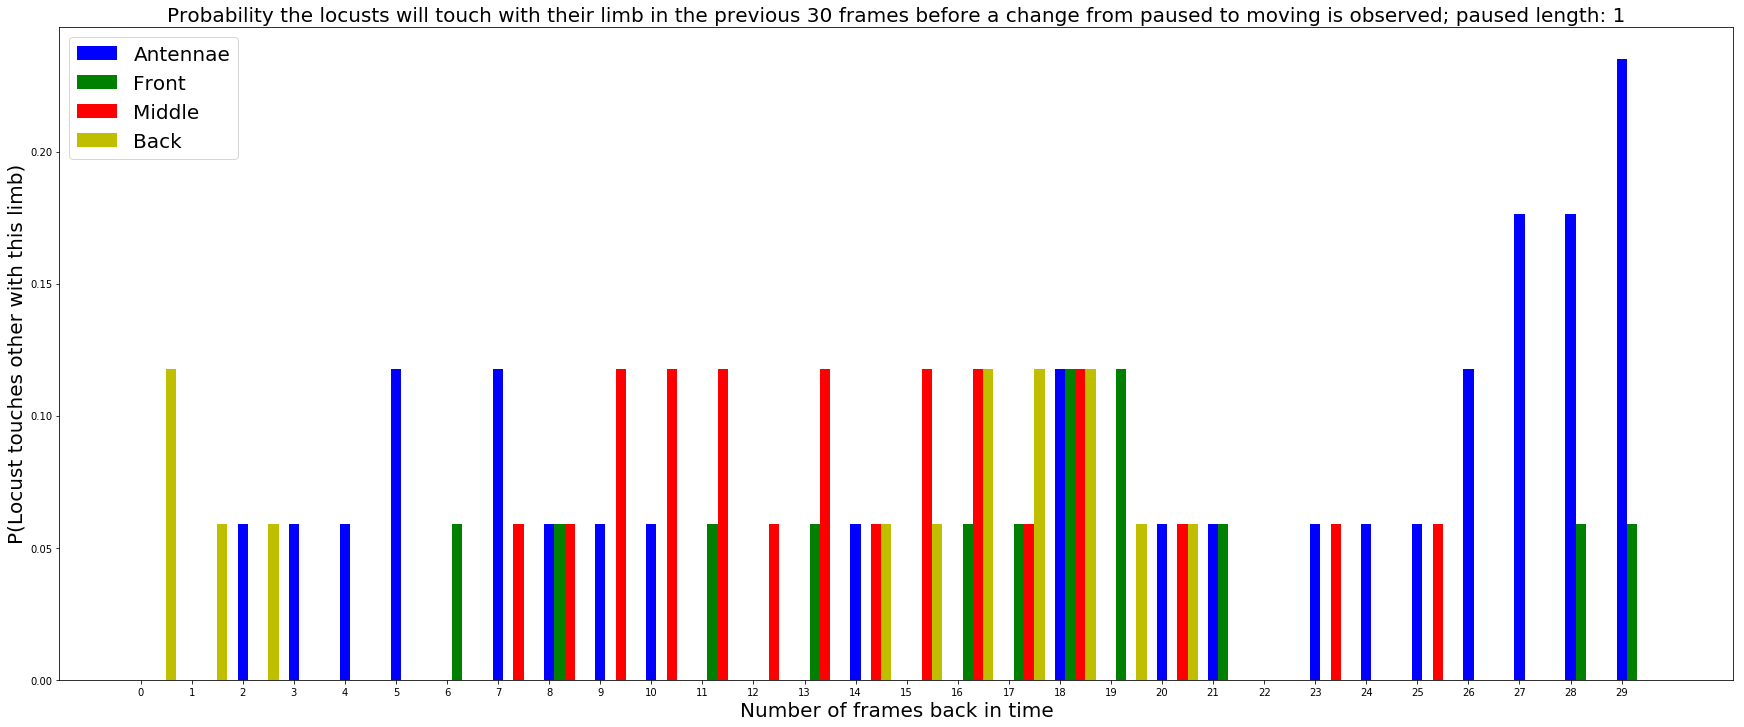

speed changes:  3


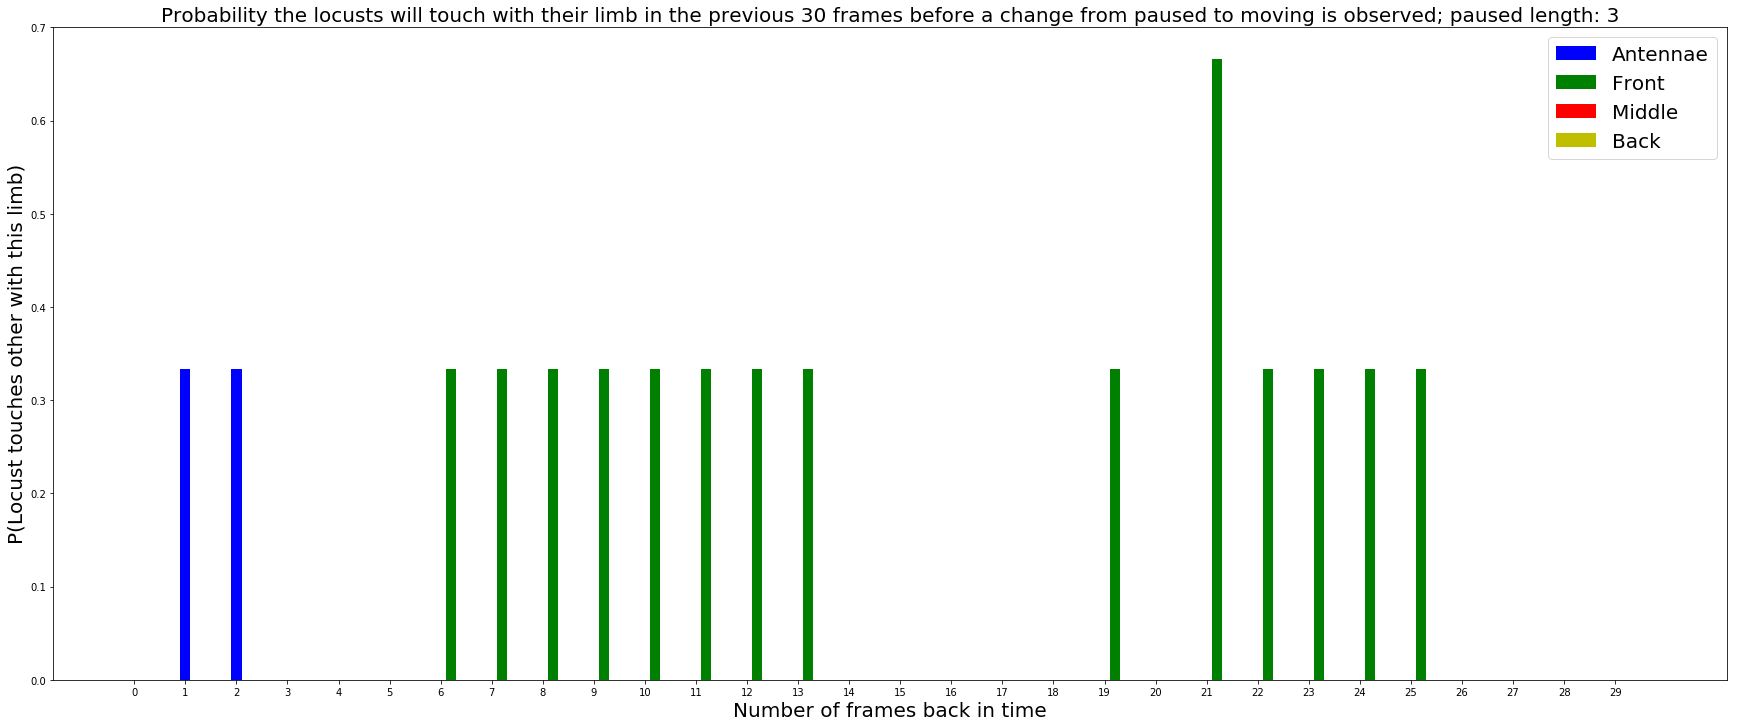

speed changes:  1


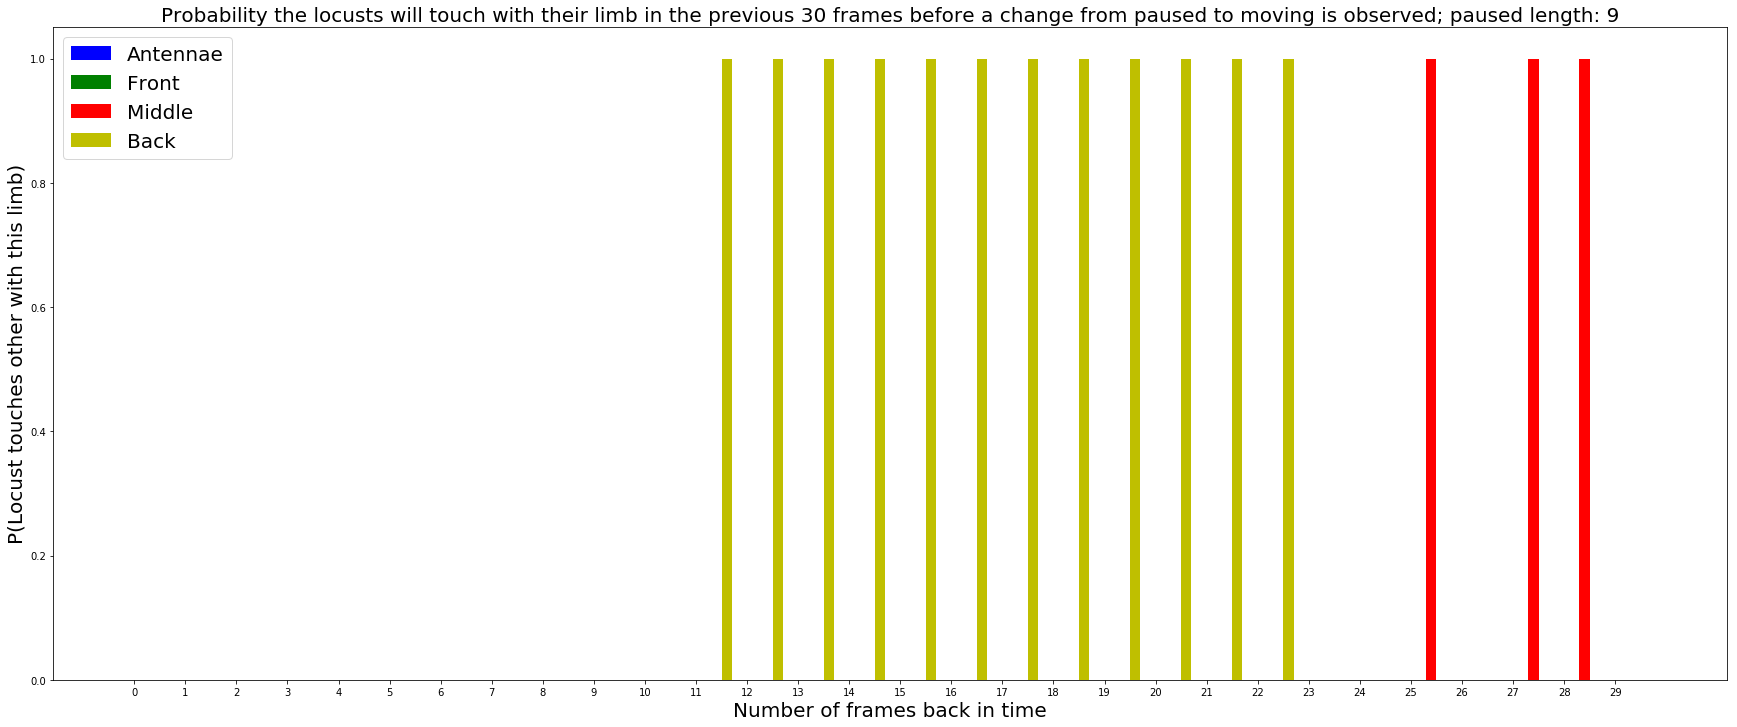

C:\Users\nmeister\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


speed changes:  0


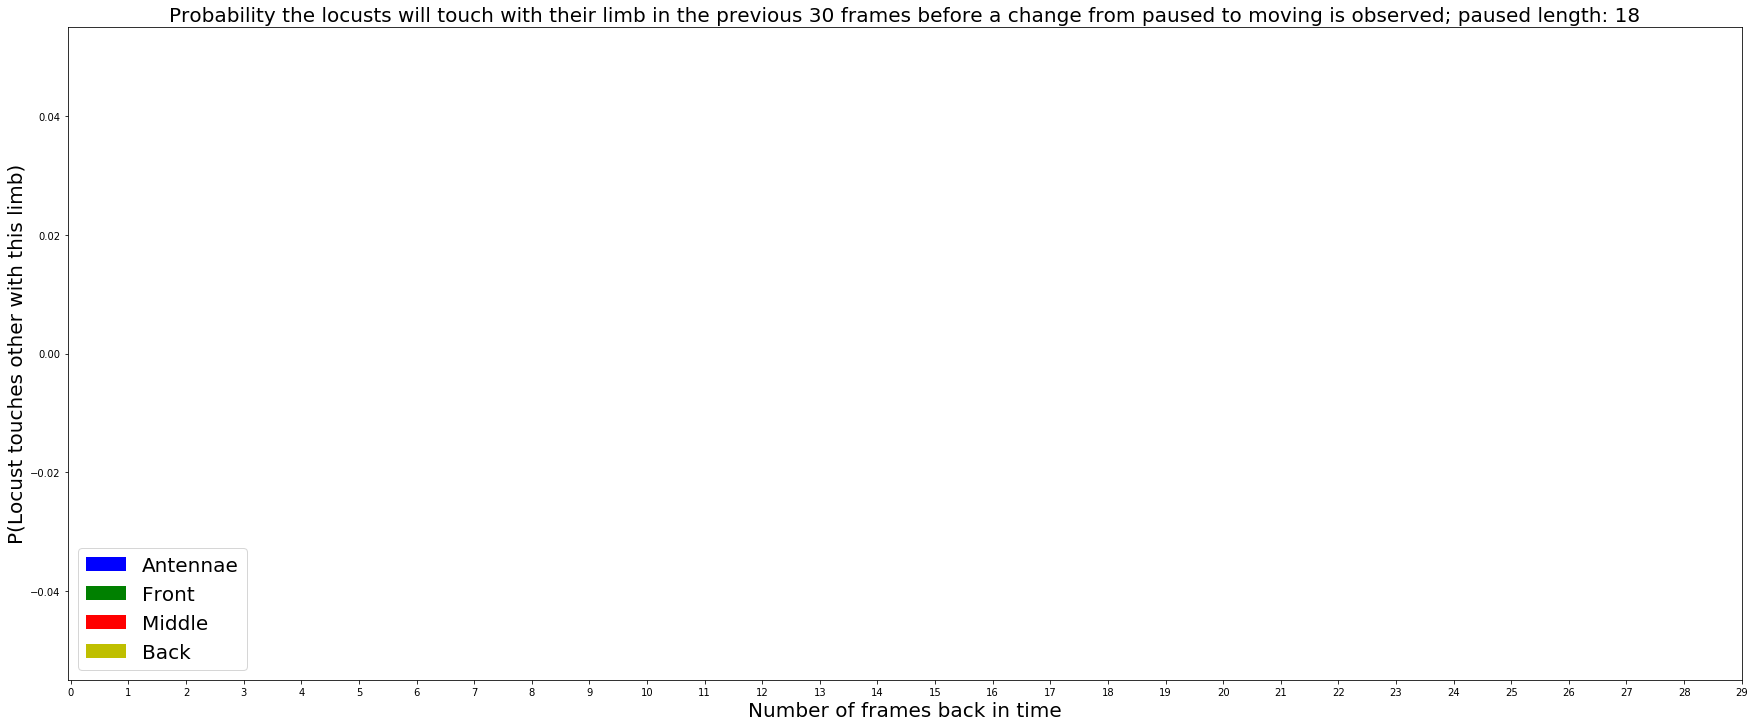

speed changes:  6


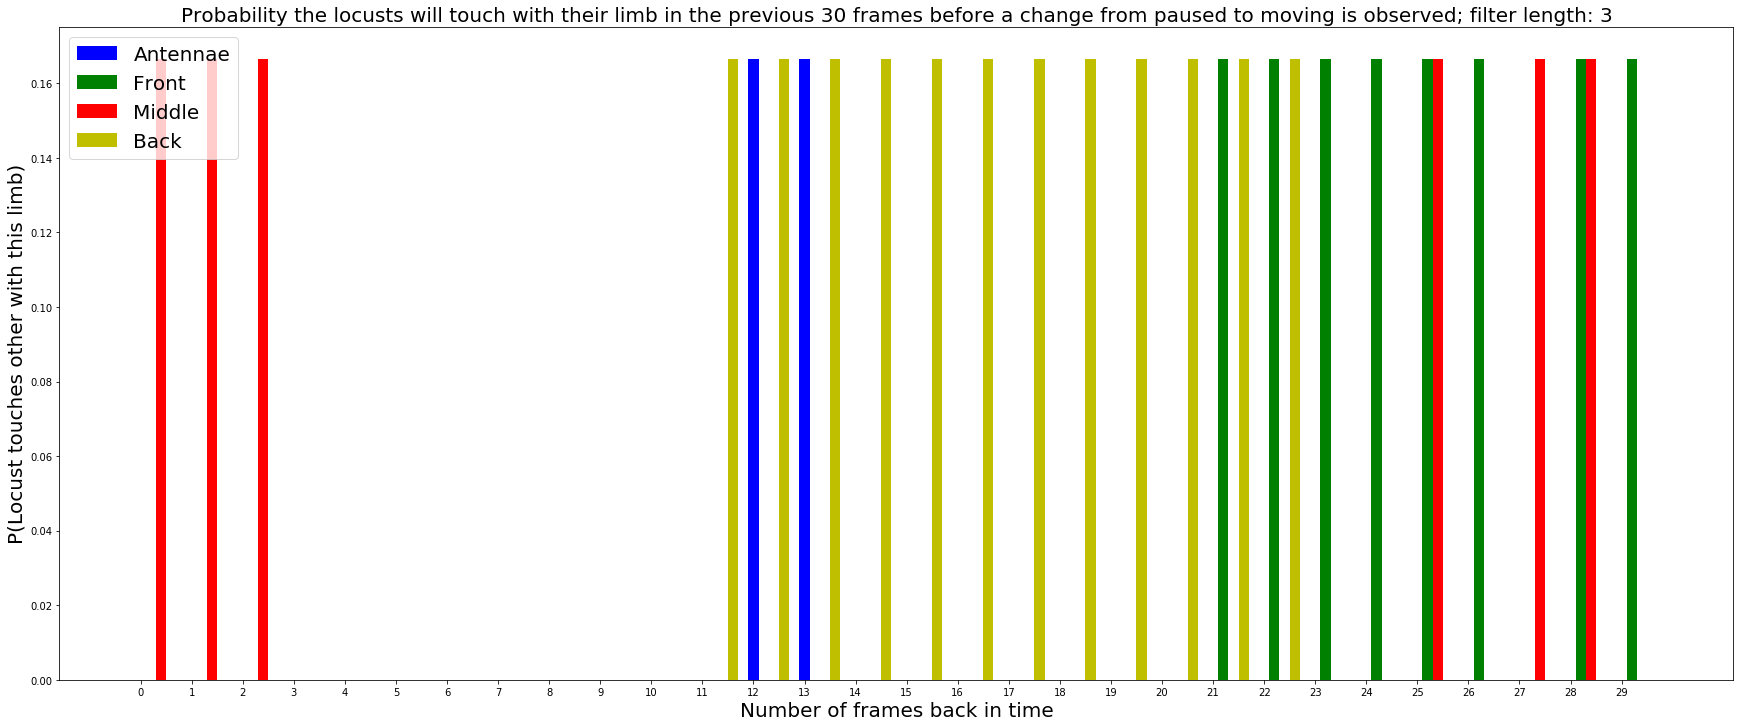

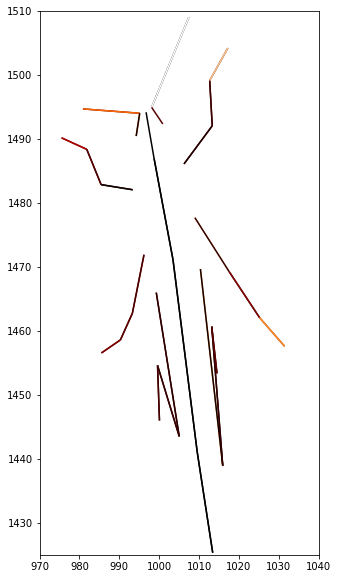

In [32]:
region = 'AFMB'

# get history of interaction where you include the paused length or greater
for pause_length in pause_lengths:
    history(X_AFMB, framesback, region, want_PL_or_Greater=True, pause_length=pause_length)

# get history of only instances with a paused length of x
for pause_length in pause_lengths:
    history(X_AFMB, framesback, region, want_PL_or_Greater=False, pause_length=pause_length)


# filter out the brief changes in motion, Keep data points where locust was paused for X frames, moving for X frames
filter_frames = 3
history(X_AFMB, framesback, region, want_PL_or_Greater=False, pause_length=np.nan, filter_frames=filter_frames)

# create heatmap of most frequent interactions per limb
heatmap(limb_count)

FB: Front, Back

In [33]:
region = 'FB'
X_FB, limb_count = classification(X_26, classification_fb)

speed changes:  41


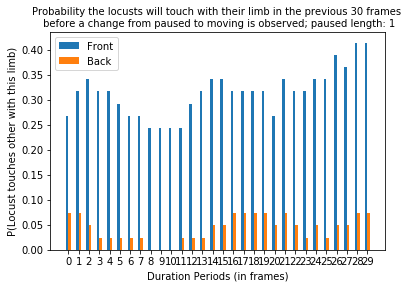

speed changes:  19


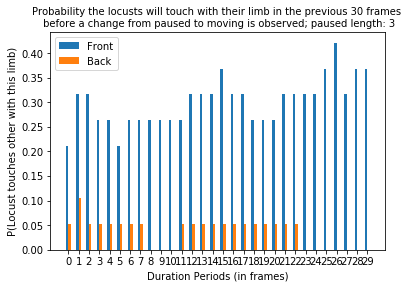

speed changes:  12


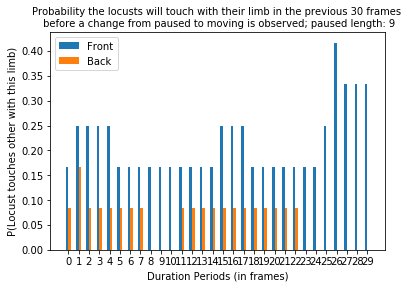

speed changes:  7


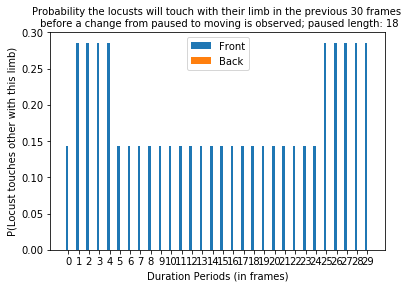

speed changes:  17


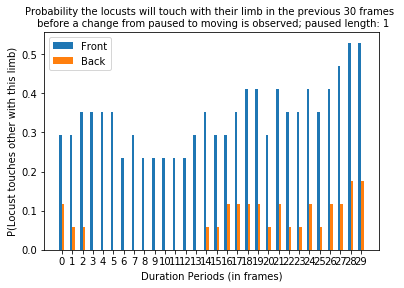

speed changes:  3


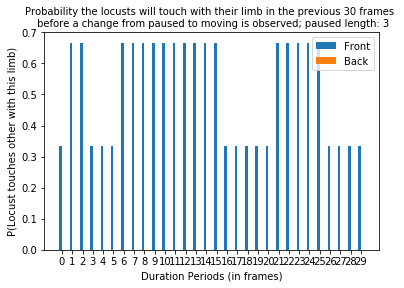

speed changes:  1


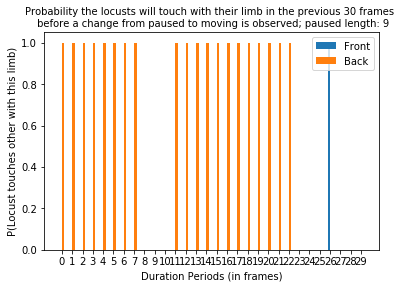

speed changes:  0


C:\Users\nmeister\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


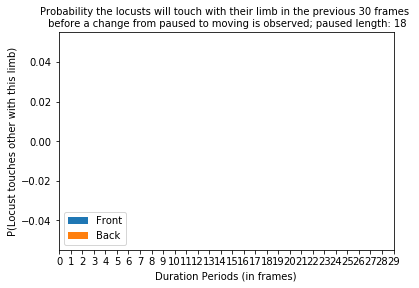

speed changes:  6


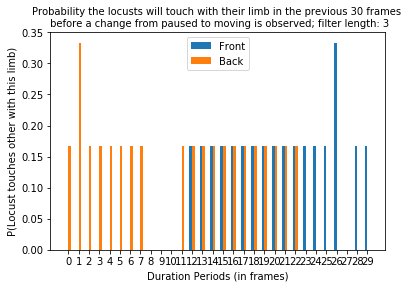

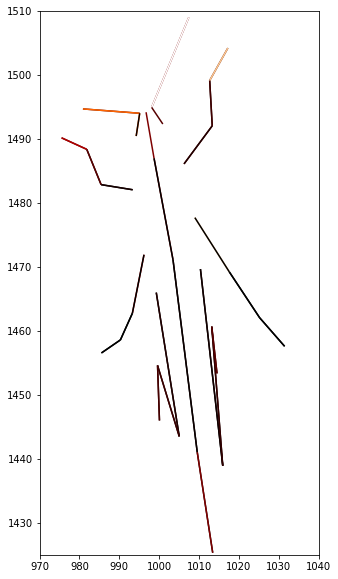

In [34]:
# get history of interaction where you include the paused length or greater
for pause_length in pause_lengths:
    history(X_FB, framesback, region, want_PL_or_Greater=True, pause_length=pause_length)

# get history of only instances with a paused length of x
for pause_length in pause_lengths:
    history(X_FB, framesback, region, want_PL_or_Greater=False, pause_length=pause_length)


# filter out the brief changes in motion, Keep data points where locust was paused for X frames, moving for X frames
filter_frames = 3
history(X_FB, framesback, region, want_PL_or_Greater=False, pause_length=np.nan, filter_frames=filter_frames)

# create heatmap of most frequent interactions per limb
heatmap(limb_count)

LR: Left/Right

In [35]:
region = 'LR'
X_LR, limb_count = classification(X_26, classification_lr)

speed changes:  41


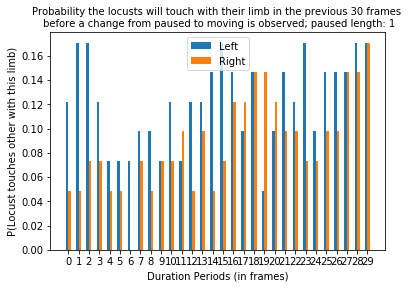

speed changes:  19


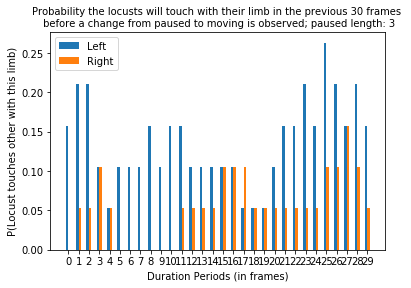

speed changes:  12


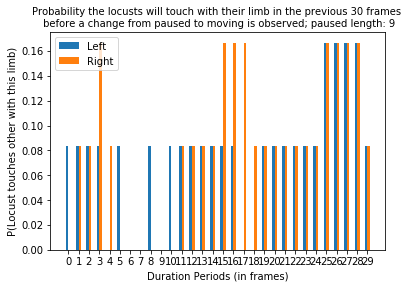

speed changes:  7


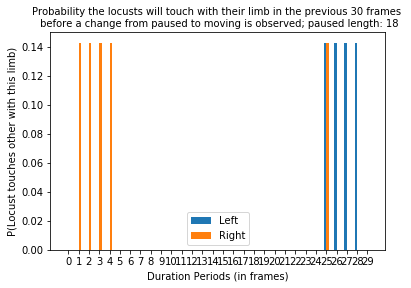

speed changes:  17


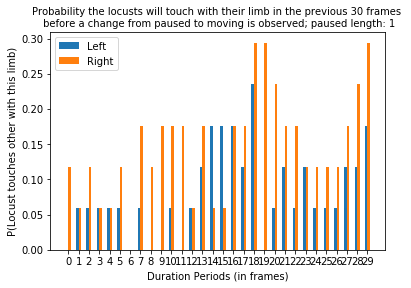

speed changes:  3


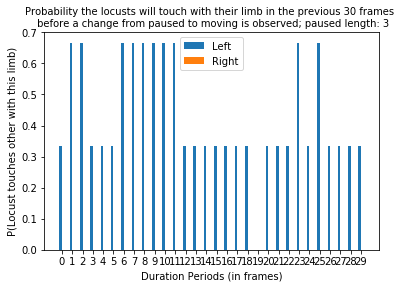

speed changes:  1


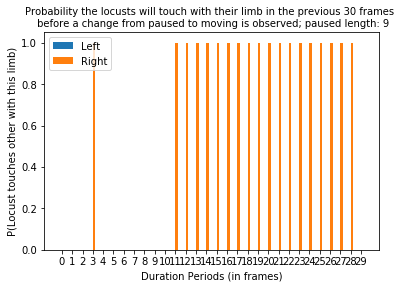

speed changes:  0


C:\Users\nmeister\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


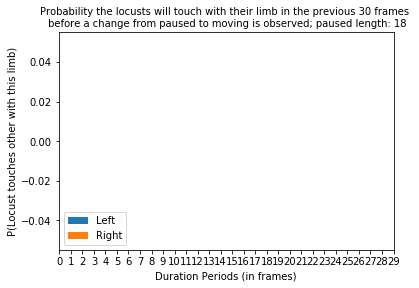

speed changes:  6


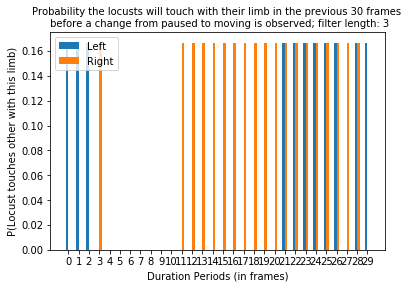

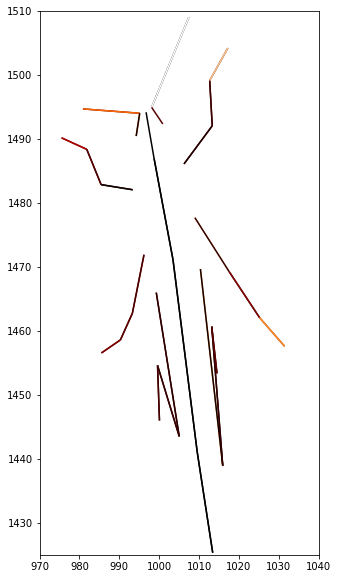

In [36]:
# get history of interaction where you include the paused length or greater
for pause_length in pause_lengths:
    history(X_LR, framesback, region, want_PL_or_Greater=True, pause_length=pause_length)

# get history of only instances with a paused length of x
for pause_length in pause_lengths:
    history(X_LR, framesback, region, want_PL_or_Greater=False, pause_length=pause_length)


# filter out the brief changes in motion, Keep data points where locust was paused for X frames, moving for X frames
filter_frames = 3
history(X_LR, framesback, region, want_PL_or_Greater=False, pause_length=np.nan, filter_frames=filter_frames)

# create heatmap of most frequent interactions per limb
heatmap(limb_count)

### Pairwise Locust's Limb Interactions

In [37]:
# X data should be 26x26
X.shape, y.shape

((103, 48, 26, 26), (103, 48, 1))

In [38]:
(neither_numb, ff_numb, fb_numb, bf_numb, bb_numb) = (0, 2, 17, 31, 61)
numb_list = [neither_numb, ff_numb, fb_numb, bf_numb, bb_numb]

Functions

In [39]:
def pairwise_classification(classification):
    # fill up newX, to determine if it is touching the front/back, left/right
    template=np.zeros((X.shape[0],X.shape[1],1))
    newX=np.full_like(template, np.nan)
    
    for locust in range(X.shape[0]):
        for frame in range(X.shape[1]):
            interaction = np.sum(X[locust, frame, :, :])
                       
            if (interaction>1): # touching multiple limbs, see if there is one overall interaction 
                rows, cols = np.array(X[locust, frame, :, :].nonzero())
                classification_sum=0
                for idx in range(len(rows)):
                    classification_sum+=fb_classify(rows[idx], cols[idx], classification_fb)
                avg_classification=0
                for numb in np.arange(1,5):
                    if (classification_sum % numb_list[numb]==0):
                        avg_classification=numb_list[numb]
                newX[locust, frame, 0] = avg_classification
                # print(avg_classification)

            if (interaction==1): # touching *one* other limb
                row, col = np.nonzero(X[locust, frame, :, :]) # get index to identify the limb
                newX[locust, frame, 0] = fb_classify(row, col, classification) # get classification             
    return newX

def fb_classify(row, col, classification):
    a,b=(classification[row], classification[col])
    # print(a,b)
    if (a,b)==(0.0, 0.0): #FF
        # print('ff')
        return ff_numb
    elif (a,b)==(0.0, 1.0): #FB
        # print('fb')
        return fb_numb
    elif (a,b)==(1.0, 0.0): #BF
        # print('bf')
        return bf_numb
    elif (a,b)==(1.0, 1.0): #BB
        # print('bb')
        return bb_numb
    else:
        # print('neither')
        return neither_numb
    
def pairwise_history(newX, framesback, pause_length):
    ff=np.zeros(framesback)
    fb=np.zeros(framesback)
    bf=np.zeros(framesback)
    bb=np.zeros(framesback)

    speed_changes = 0
    for individ in range(y.shape[0]):
        for frame in range(framesback, y.shape[1]):
            past=0
            for prev in range(pause_length):
                past += y[individ, frame-(prev+1)] # 0
            # if the locust has a consecutive pause of length (pause_length) and it goes into moving state
            if past==0 and y[individ, frame-(pause_length+1)]==1: 
            # if the locust moves from paused to moving
                if (y[individ, frame] - y[individ, frame-1])==1: 
                    speed_changes+=1
                    # get array of past X frames
                    # to do: check for a consecutive pause
                    for frameback in range(framesback):
                        if newX[individ, frame-frameback]==ff_numb:
                            ff[frameback]+=1
                        if newX[individ, frame-frameback]==fb_numb:
                            fb[frameback]+=1
                        if newX[individ, frame-frameback]==bf_numb:
                            bf[frameback]+=1
                        if newX[individ, frame-frameback]==bb_numb:
                            bb[frameback]+=1
    print("speed changes: ", speed_changes)
    return ff, fb, bf, bb, speed_changes

def plot_pairwise(ff, fb, bf, bb, framesback, pause_length):
    
    ind = np.arange(framesback)  # the x locations for the groups
    width=0.15
    fig, ax = plt.subplots()

    X = np.arange(framesback)
    p1=ax.bar(X + 0.00, ff, color = 'b', width = width)
    p2=ax.bar(X + 0.15, fb, color = 'g', width = width)
    p3=ax.bar(X + 0.30, bf, color = 'y', width = width)
    p4=ax.bar(X + 0.45, bb, color = 'r', width = width)
    # p5=ax.bar(X + 0.60, neither, color = 'm', width = width)

    ax.set_xlabel('Number of frames back in time', fontsize=20)
    ax.set_ylabel('P (Moving Locust)', fontsize=20)
    ax.set_title('Probability the locusts will engage in the interaction in the previous %d frames before a change from paused to moving is observed; paused length: %d' % (framesback, pause_length), fontsize=20)
    ax.set_xticks(np.arange(framesback))
    ax.legend((p1[0], p2[0], p3[0], p4[0]), ('FF', 'FB', 'BF', 'BB'), fontsize=20)
    fig.set_size_inches((40, 12))
    
    fig.savefig('./plots/pairwise/pairwise_%d.png' % pause_length)
    plt.show()
    
def get_duration(pairwise_X, numb, locust, frame, marked):
    if pairwise_X[locust, frame, 0]==numb:
        length=0
        while pairwise_X[locust, frame, 0]==numb:
            marked[locust, frame, 0]=True
            length+=1
            if frame==(pairwise_X.shape[1]-1):
                break
            else: 
                frame+=1
    return length, marked

Plots

In [40]:
pairwise_X = pairwise_classification(classification_fb)

speed changes:  17


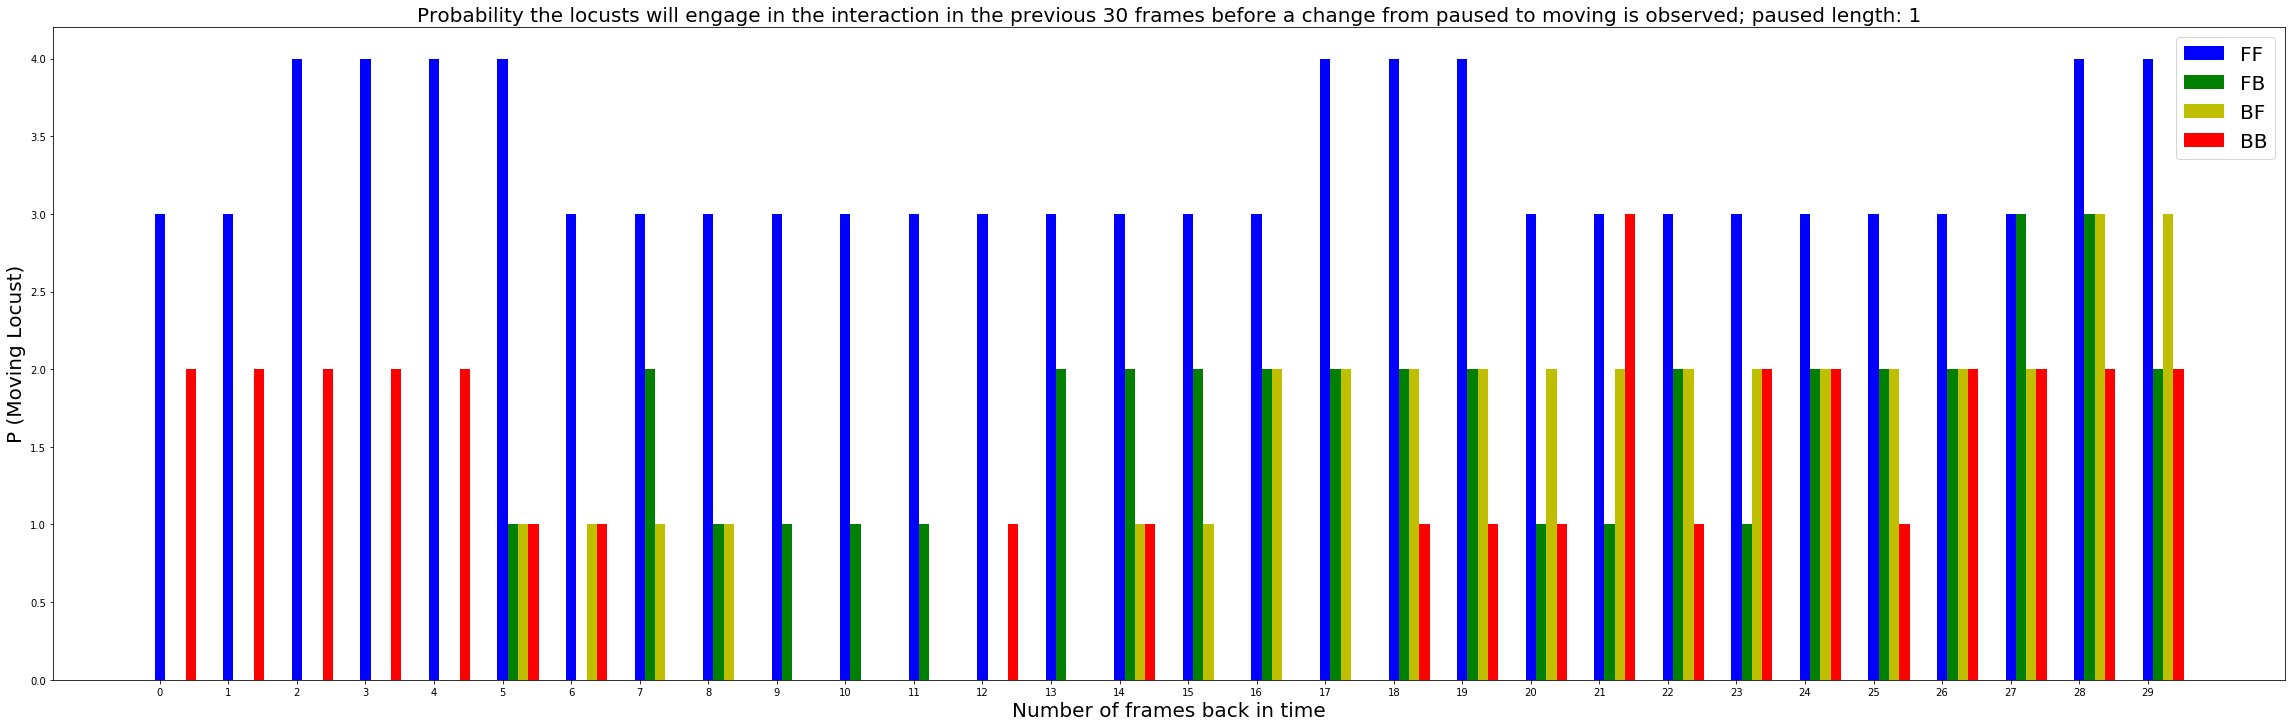

speed changes:  3


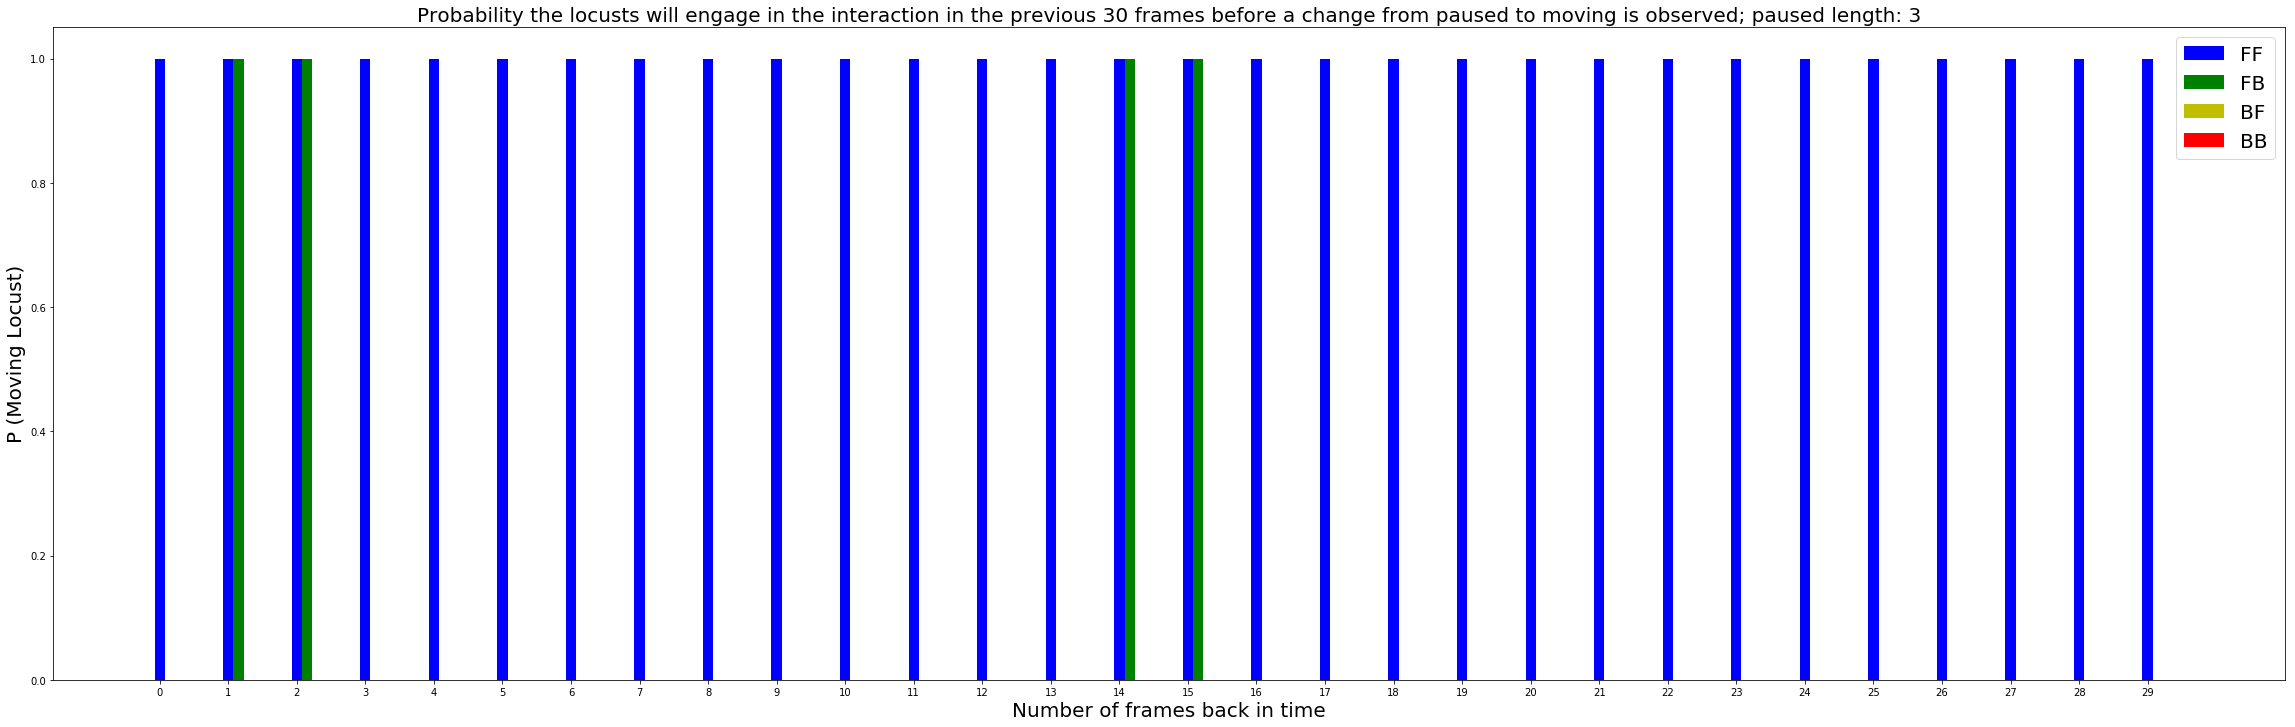

speed changes:  1


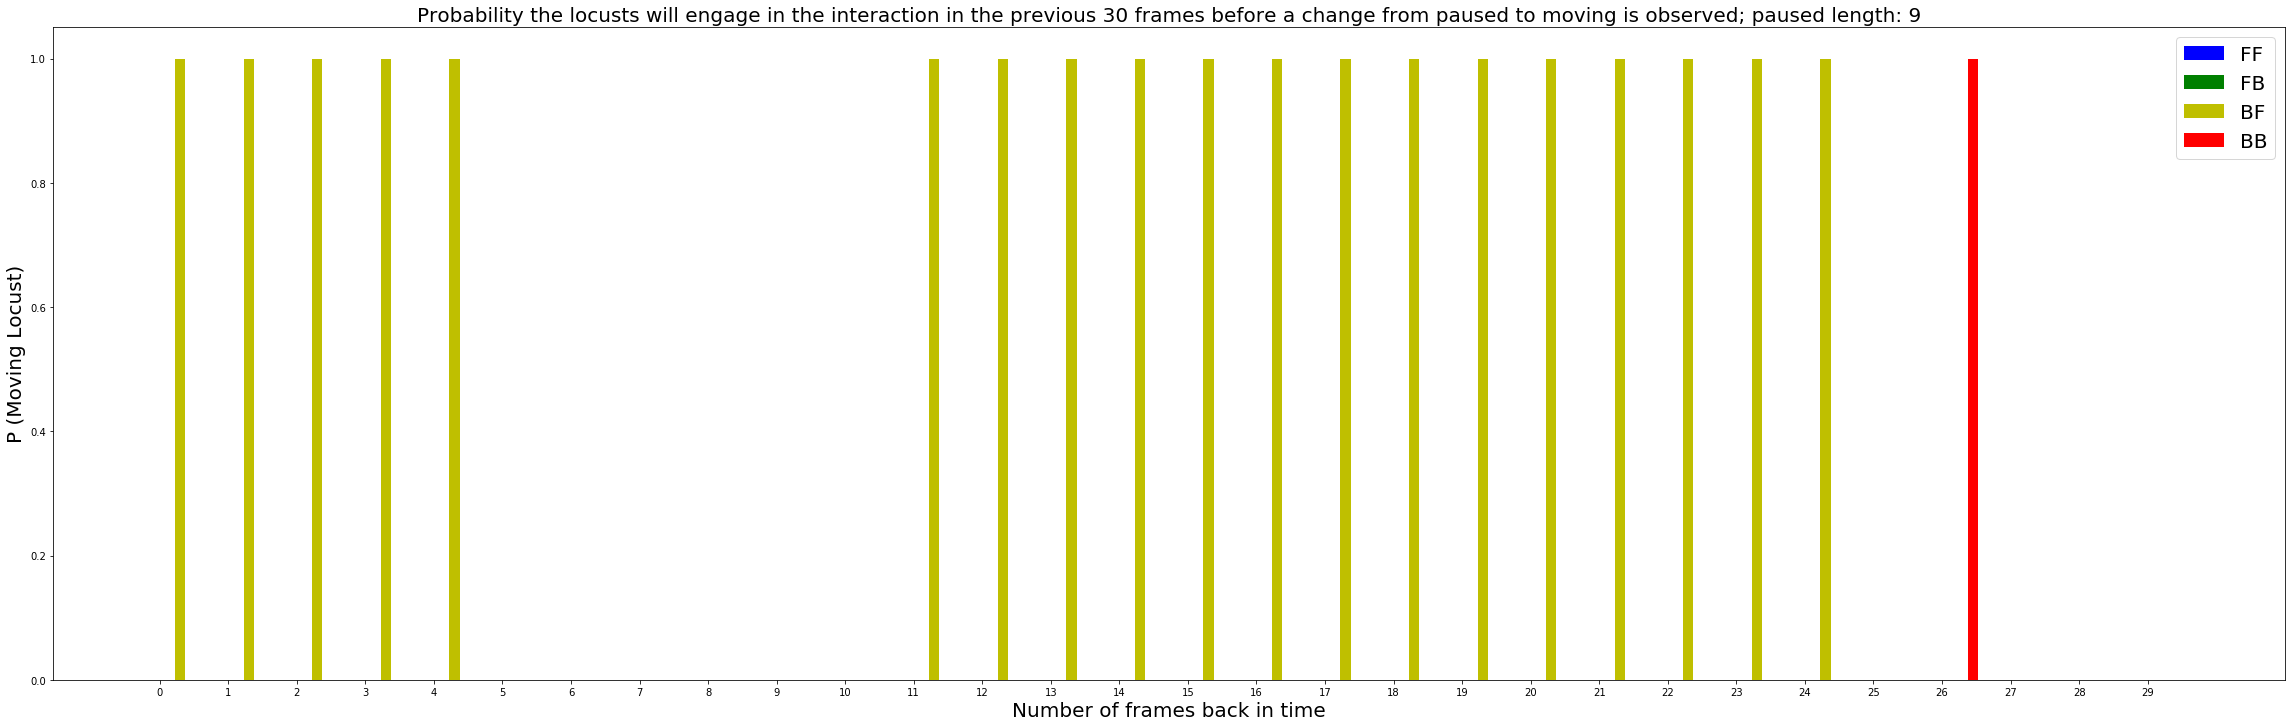

speed changes:  0


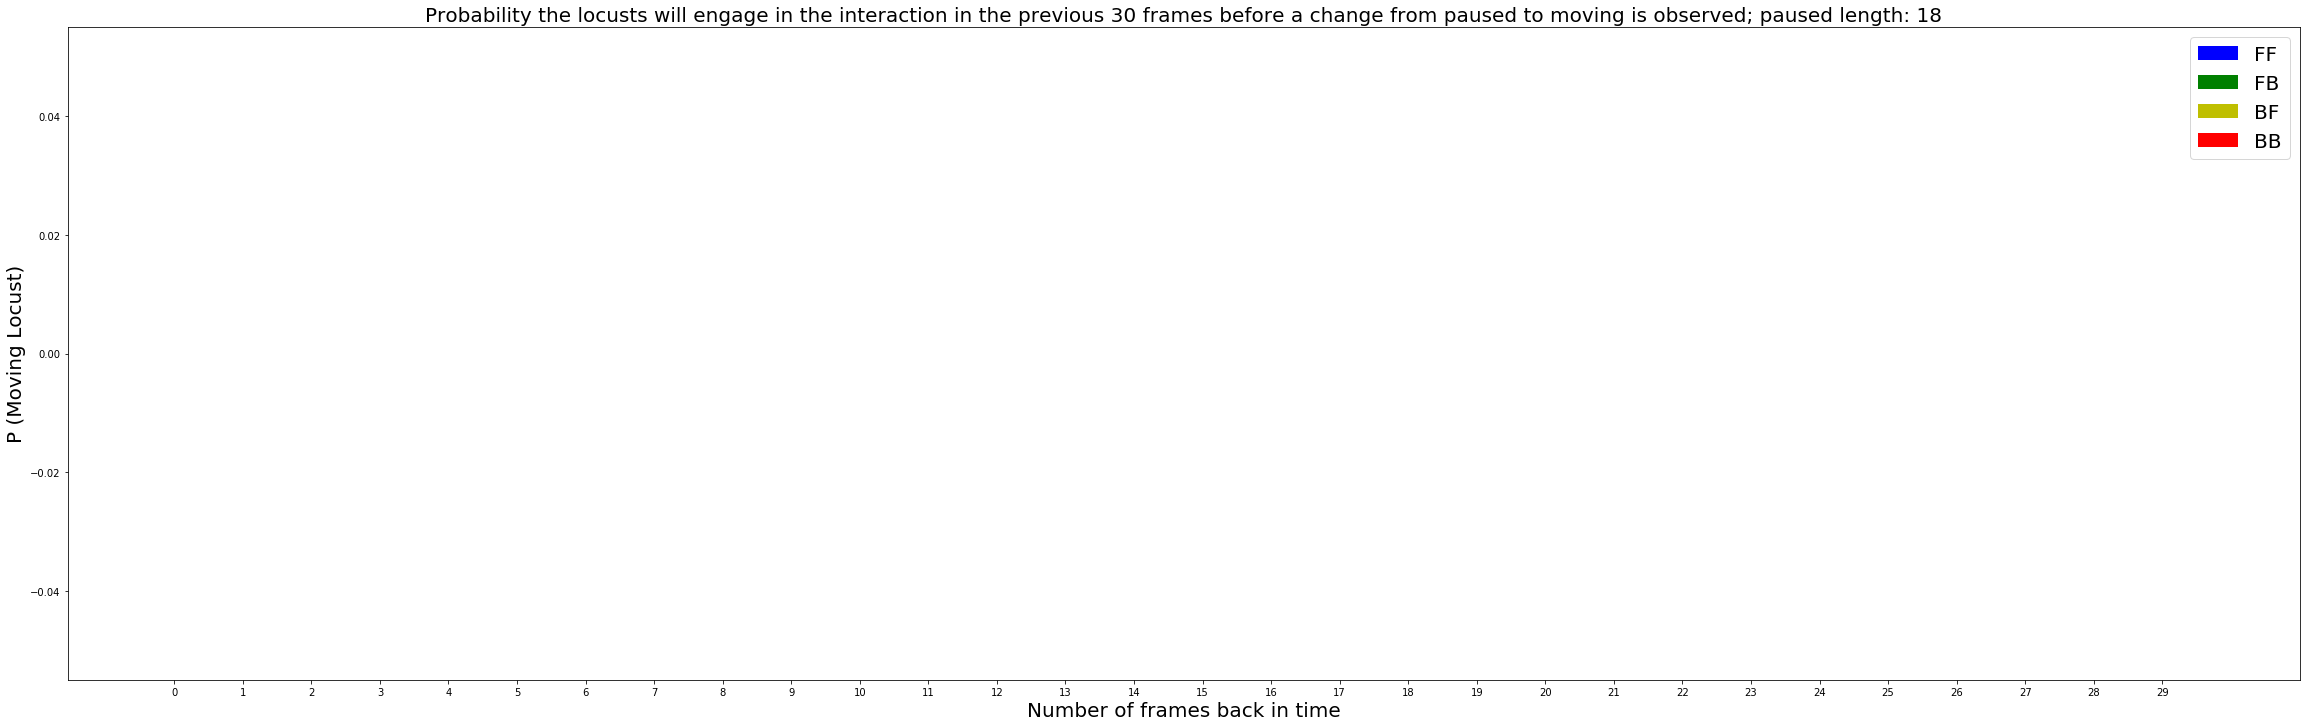

In [41]:
for pause_length in pause_lengths:
    ff, fb, bf, bb, speed_changes = pairwise_history(pairwise_X, framesback=framesback, pause_length=pause_length)
    plot_pairwise(ff, fb, bf, bb, framesback, pause_length=pause_length)

In [42]:
# get avg length of interactions
marked = np.zeros((pairwise_X.shape), dtype=bool)

ff_length=[]
fb_length=[]
bf_length=[]
bb_length=[]

for locust in range(pairwise_X.shape[0]):
    for frame in range(pairwise_X.shape[1]):
        if not marked[locust, frame, 0]:
            if pairwise_X[locust, frame, 0]==ff_numb:
                length, marked = get_duration(pairwise_X, ff_numb, locust, frame, marked)
                ff_length.append(length)
            if pairwise_X[locust, frame, 0]==fb_numb:
                length, marked = get_duration(pairwise_X, fb_numb, locust, frame, marked)
                fb_length.append(length)
            if pairwise_X[locust, frame, 0]==bf_numb:
                length, marked = get_duration(pairwise_X, bf_numb, locust, frame, marked)
                bf_length.append(length)
            if pairwise_X[locust, frame, 0]==bb_numb:
                length, marked = get_duration(pairwise_X, bb_numb, locust, frame, marked)
                bb_length.append(length)

In [43]:
def histo(region, counts):
    num_bins =  1 + int(3.322*math.log(len(ff_length)))
    n, bins, patches = plt.hist(ff_length, num_bins, facecolor='blue', log=True)
    plt.title('Distribution of Length of %s Interactions across the Entire Experiment' % region)
    plt.xlabel('Length of the Interaction (frames)')
    plt.ylabel('Count (log scale)')
    plt.savefig('./plots/pairwise/%s_length_histo.png' % (region))
    plt.show

FileNotFoundError: [Errno 2] No such file or directory: './plots/FF/FF_length_histo.png'

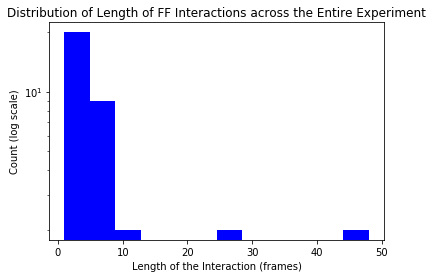

In [44]:
histo('FF', ff_length)
histo('FB', fb_length)
histo('BF', bf_length)
histo('BB', bb_length)